/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_13471/2878898578.py:41: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator()
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_13471/2878898578.py:36: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


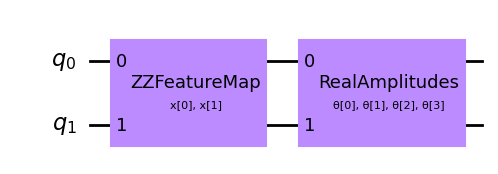

/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_13471/2878898578.py:41: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator()
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_13471/2878898578.py:36: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_13471/2878898578.py:41: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than

In [17]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import matplotlib.pyplot as plt

RANGE = 1
RANDOM_SEED = 42
N_SAMPLES = 100

def sample_data(dist_type='gaussian', n_samples=N_SAMPLES) : 
    if dist_type == 'gaussian' : 
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=RANDOM_SEED)
    elif dist_type == 'uniform' : 
        X = np.random.uniform(-RANGE, RANGE, size=(n_samples, 2))
        y = (X[:, 0] * X[:, 1] > 0).astype(int)
    elif dist_type == 'moon' : 
        X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=RANDOM_SEED)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def build_qnn(n_qubits=2, print_circuit=False) : 
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1, entanglement='linear')
    from qiskit import QuantumCircuit
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    observable = [SparsePauliOp(Pauli('ZI'))]
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        observables=observable,
        estimator=Estimator()
    )
    if print_circuit : 
        display(qc.draw(output='mpl', style='clifford'))
    return qnn

# for visualizing constructed quantum circuit
X_sample, _ = sample_data('gaussian')
qnn_model_sample = build_qnn(print_circuit=True)

from qiskit_machine_learning.neural_networks import EffectiveDimension

num_input_samples = 50
num_weight_samples = 100

distributions = ['gaussian', 'uniform', 'moon']
ed_results = {}

for dist in distributions : 
    qnn_model = build_qnn()
    X, _ = sample_data(dist)
    X_input = X[:num_input_samples].numpy()
    ed_list = []
    for _ in range(100) : 
        ed = EffectiveDimension(
            qnn=qnn_model, weight_samples=num_weight_samples, input_samples=X_input
        ).get_effective_dimension(dataset_size=N_SAMPLES)
        ed_list.append(ed)
    ed_results[dist] = ed_list        

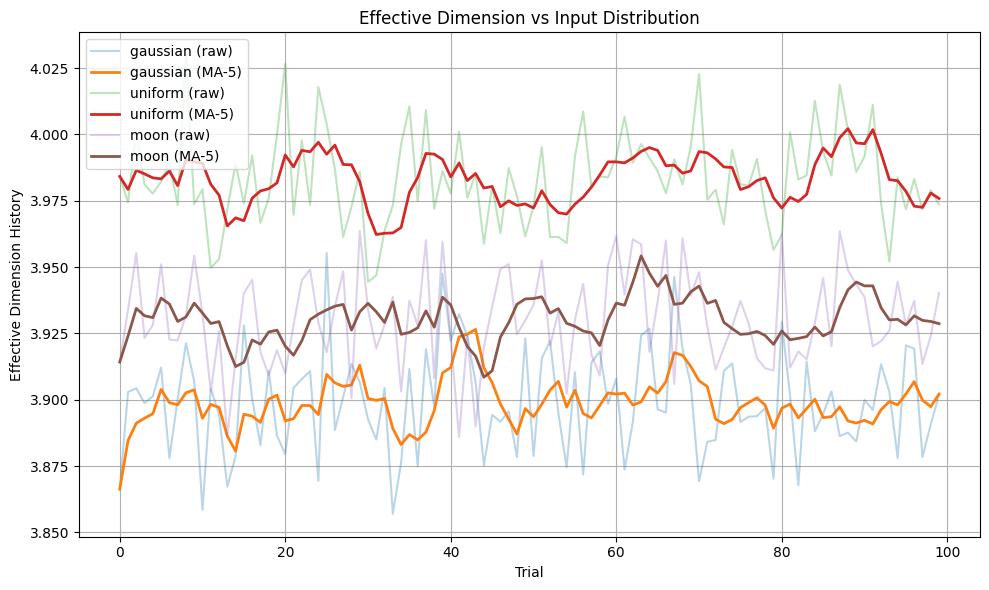

In [18]:
import pandas as pd

plt.figure(figsize=(10, 6))
for dist in distributions : 
    ed_series = pd.Series(ed_results[dist])
    rolling_avg = ed_series.rolling(window=5, min_periods=1).mean()
    
    plt.plot(ed_results[dist], label=f'{dist} (raw)', alpha=0.3)
    plt.plot(rolling_avg, label=f'{dist} (MA-5)', linewidth=2)

plt.title('Effective Dimension vs Input Distribution')
plt.xlabel('Trial')
plt.ylabel('Effective Dimension History')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
for dist in distributions : 
    ed_array = np.array(ed_results[dist])
    print(f'\nMean of the distribution {dist} : {np.mean(ed_array)}')
    print(f'Std of the distribution {dist} : {np.std(ed_array)}')


Mean of the distribution gaussian : 3.8990296333164833
Std of the distribution gaussian : 0.019368598455426028

Mean of the distribution uniform : 3.9829936517718814
Std of the distribution uniform : 0.017238848634294965

Mean of the distribution moon : 3.9303341669716354
Std of the distribution moon : 0.017889067633815474


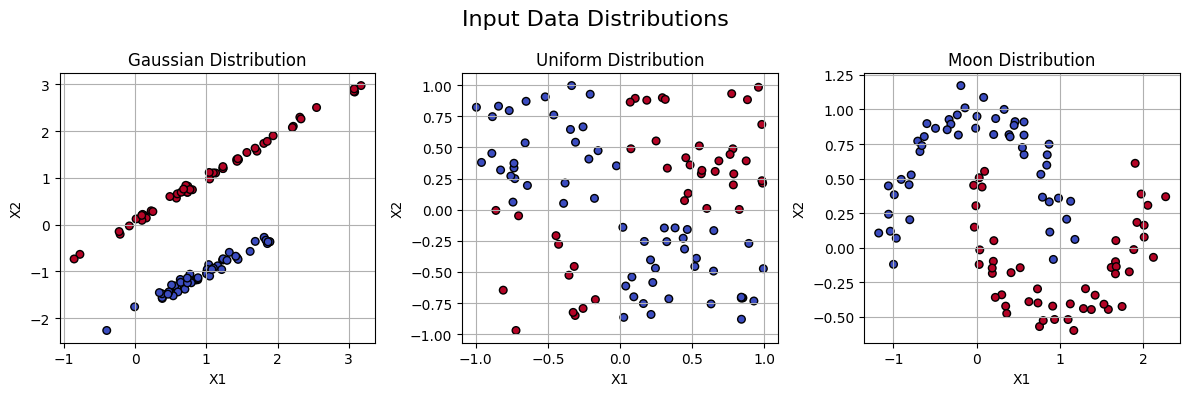

In [20]:
fig, axes = plt.subplots(1, len(distributions), figsize=(4 * len(distributions), 4))
for i, dist in enumerate(distributions) : 
    X, y = sample_data(dist)
    X = X.numpy()
    y = y.numpy()

    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=30)
    ax.set_title(f'{dist.capitalize()} Distribution')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.grid(True)

plt.suptitle('Input Data Distributions', fontsize=16)
plt.tight_layout()
plt.show()